Data Cleaning and Preprocessing

Analyzing the data

In [1]:
import pandas as pd

# Because the script and data are in the same folder, the path is just the filename.
file_path = 'online_retail_II.xlsx'

# Load the data
df = pd.read_excel(file_path)

# Display the first few rows to check it
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


1. Handling Missing Customer IDs

First, will see how much data is missing.

In [2]:
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


Since a large number of missing values are there in the Customer ID column.

The Problem: Customer Lifetime Value is a customer-centric metric. If a transaction doesn't have a Customer ID, we can't assign it to any customer. Therefore, these rows are unusable for our specific goal.

The Solution: We will remove all rows where the Customer ID is missing.

In [3]:
print("Original shape:", df.shape)

df.dropna(subset=['Customer ID'], inplace=True)

print("Shape after dropping NaNs:", df.shape)
print(df.isnull().sum())

Original shape: (525461, 8)
Shape after dropping NaNs: (417534, 8)
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


2. Removing Canceled Orders

In this dataset, canceled orders are marked with an Invoice number that starts with the letter 'C'. These entries also have negative quantities.

The Problem: Canceled orders represent returned goods, not revenue. Including them would incorrectly reduce customer spending and skew our CLV calculations.

The Solution: We will filter out all rows where the Invoice number starts with 'C'.

In [4]:
df['Invoice'] = df['Invoice'].astype(str)

df = df[~df['Invoice'].str.startswith('C')]

df = df[df['Quantity'] > 0]

3. Removing Rows with Zero Price

Some items have a price of 0.0. These could be promotional items, test entries, or bad data.

The Problem: A transaction with zero value adds no monetary information and can cause errors in some statistical models (like the Gamma-Gamma model we'll use later).

The Solution: We will remove any rows where the price is zero.

In [5]:
df = df[df['Price'] > 0]

4. Creating the TotalPrice Column

Our model needs to know the total monetary value of each transaction line.

The Need: We need a single column that represents the total value for each line item in the dataset.

The Solution: Create a new column called TotalPrice by multiplying Quantity by Price.

In [6]:
df['TotalPrice'] = df['Quantity'] * df['Price']

5. Converting Data Types

let's ensure our columns have the correct data types for future calculations.

The Problem: The Customer ID, which we dropped NaNs from, might be a float (e.g., 12345.0). The InvoiceDate is likely an object (string) instead of a proper datetime object.

The Solution: Convert Customer ID to an integer and InvoiceDate to a datetime object. This is crucial for performing time-based calculations like recency and creating cohorts.

In [7]:

df['Customer ID'] = df['Customer ID'].astype(int)

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407664 non-null  object        
 1   StockCode    407664 non-null  object        
 2   Description  407664 non-null  object        
 3   Quantity     407664 non-null  int64         
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   Price        407664 non-null  float64       
 6   Customer ID  407664 non-null  int64         
 7   Country      407664 non-null  object        
 8   TotalPrice   407664 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.1+ MB
None


In [8]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,407664.000000,407664,407664.000000,407664.000000,407664.000000
mean,13.585585,2010-07-01 10:15:11.871688192,3.294438,15368.592598,21.664909
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000,0.001000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000,4.950000
50%,5.000000,2010-07-09 15:47:00,1.950000,15321.000000,11.900000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000,15818.400000
std,96.840747,NaN,34.757965,1679.762138,77.150058


In [9]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


 Cohort Analysis

 Objective: To group customers into cohorts based on when they made their first purchase and track how many of them return to make subsequent purchases over time. This will help you understand customer loyalty and retention.

1. Creation of Cohort and Invoice Month Columns

First, we need to assign each customer to a cohort. A cohort is defined by the month of the customer's very first purchase.

In [10]:
import pandas as pd

df['CohortMonth'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

2. Calculate Cohort Index

Next, for each transaction, we'll calculate a "cohort index". This is an integer representing how many months have passed since the customer's first purchase. For example, the month of the first purchase is index 0, the next month is index 1, and so on.

In [11]:
def get_cohort_index(df, cohort_month_col='CohortMonth', invoice_month_col='InvoiceMonth'):
    """
    Calculates the cohort index for each transaction.
    Cohort index is the number of months since the customer's first purchase.
    """
    year_diff = df[invoice_month_col].dt.year - df[cohort_month_col].dt.year
    month_diff = df[invoice_month_col].dt.month - df[cohort_month_col].dt.month
    return year_diff * 12 + month_diff + 1

df['CohortIndex'] = get_cohort_index(df)

3. Create the Cohort Retention Matrix

Now we'll create a pivot table to see how many unique customers from each cohort were active in each subsequent month (CohortIndex).

In [12]:
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()

cohort_counts = cohort_data.pivot_table(index='CohortMonth',
                                        columns='CohortIndex',
                                        values='Customer ID')

print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2009-12      955.0  337.0  319.0  406.0  363.0  343.0  360.0  327.0  321.0   
2010-01      383.0   79.0  119.0  117.0  101.0  115.0   99.0   88.0  107.0   
2010-02      374.0   89.0   84.0  109.0   92.0   75.0   72.0  107.0   95.0   
2010-03      443.0   84.0  102.0  107.0  103.0   90.0  109.0  134.0  122.0   
2010-04      294.0   57.0   57.0   48.0   54.0   66.0   81.0   77.0   20.0   
2010-05      254.0   40.0   43.0   44.0   45.0   65.0   54.0   20.0    NaN   
2010-06      270.0   47.0   51.0   55.0   62.0   77.0   18.0    NaN    NaN   
2010-07      186.0   29.0   34.0   55.0   54.0   19.0    NaN    NaN    NaN   
2010-08      162.0   33.0   48.0   52.0   19.0    NaN    NaN    NaN    NaN   
2010-09      243.0   55.0   57.0   24.0    NaN    NaN    NaN    NaN    NaN   
2010-10      377.0   97.0   35.0    NaN    NaN    NaN    NaN    

4. Calculate Retention Rate

Absolute numbers are good, but retention rates (percentages) are better for comparison. We'll divide each number in the table by the initial size of that cohort (the value in the first column, CohortIndex = 1).

In [13]:
cohort_sizes = cohort_counts.iloc[:, 0]

cohort_retention = cohort_counts.divide(cohort_sizes, axis=0)

cohort_retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2009-12,100.0,35.3,33.4,42.5,38.0,35.9,37.7,34.2,33.6,36.2,42.2,49.5,24.8
2010-01,100.0,20.6,31.1,30.5,26.4,30.0,25.8,23.0,27.9,31.9,30.3,9.9,NaN
2010-02,100.0,23.8,22.5,29.1,24.6,20.1,19.3,28.6,25.4,27.5,7.2,NaN,NaN
2010-03,100.0,19.0,23.0,24.2,23.3,20.3,24.6,30.2,27.5,7.9,NaN,NaN,NaN
2010-04,100.0,19.4,19.4,16.3,18.4,22.4,27.6,26.2,6.8,NaN,NaN,NaN,NaN
2010-05,100.0,15.7,16.9,17.3,17.7,25.6,21.3,7.9,NaN,NaN,NaN,NaN,NaN
2010-06,100.0,17.4,18.9,20.4,23.0,28.5,6.7,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,15.6,18.3,29.6,29.0,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,20.4,29.6,32.1,11.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5. Visualize the Retention Rate with a Heatmap

This is the key deliverable of this step. A heatmap makes the retention table easy to interpret at a glance.

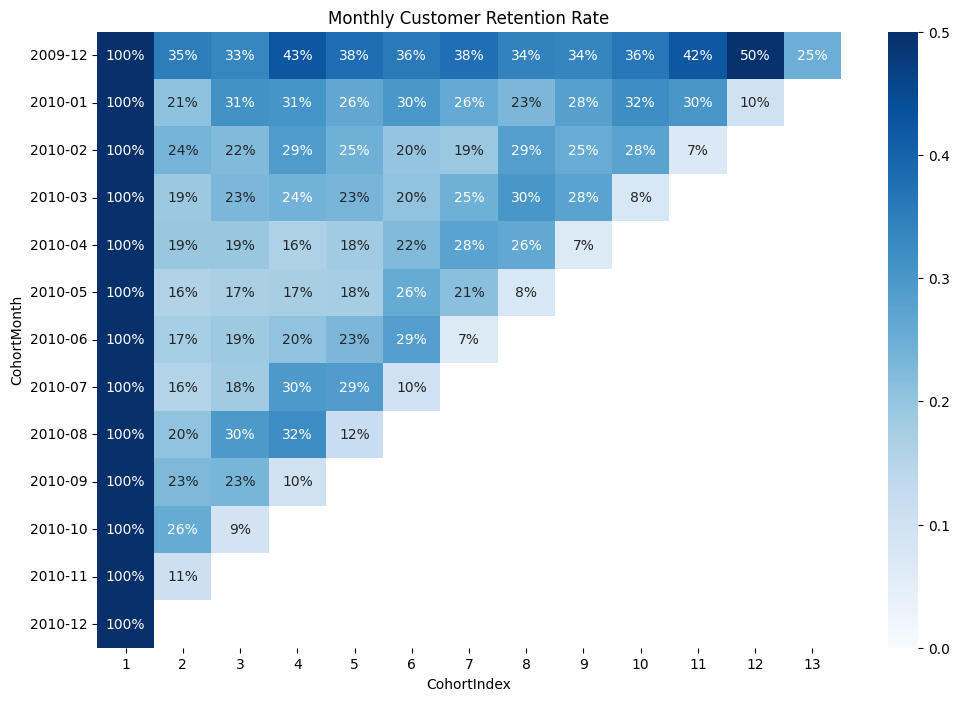

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.title('Monthly Customer Retention Rate')

sns.heatmap(data=cohort_retention,
            annot=True,       
            fmt='.0%',         
            vmin=0.0,
            vmax=0.5,          
            cmap='Blues')      
plt.show()

Each row is a cohort. The first column (1) is always 100% because it represents the month all those customers started. As you move right, the percentage shows how many of that original group came back in the following months.The colors fading from dark to light show customer churn. A sharp drop-off after the first month is common.Are newer cohorts (bottom rows) retaining better or worse than older cohorts (top rows)? This can indicate if your business strategies are improving over time.

We have now turned raw data into a powerful visualization of customer behavior! The next step is to prepare the data for our predictive model.

Feature Engineering for CLV Modeling

 To transform our transaction-level data into a customer-level summary table with Recency, Frequency, Monetary (RFM) features. This specific RFM format is required by our predictive library, lifetimes

 1. Understanding the RFM Features for lifetimes

 The lifetimes library uses a specific definition for its RFM inputs:


Frequency: The number of repeat purchases. A customer who bought 3 times has a frequency of 2. A customer who bought only once has a frequency of 0.

Recency: The time between a customer's first and last purchase. This is the age of the customer when they made their last transaction.

T (Tenure): The time between a customer's first purchase and the end of the observation period. This is the total age of the customer in our dataset.

Monetary Value: The average value of a customer's repeat purchases. This is calculated only for customers with a frequency greater than 0.

2. Using the lifetimes Utility Function

Manually calculating these values would be tedious. Luckily, the lifetimes library provides a powerful utility function, summary_data_from_transaction_data, that does all the work for us.

In [15]:
from lifetimes.utils import summary_data_from_transaction_data

observation_period_end = df['InvoiceDate'].max() + pd.DateOffset(days=1)

rfm_df = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=observation_period_end
)

print(rfm_df.head())

             frequency  recency      T  monetary_value
Customer ID                                           
12346              6.0    196.0  361.0       47.143333
12347              1.0     37.0   40.0      711.790000
12348              0.0      0.0   74.0        0.000000
12349              2.0    182.0  225.0      801.310000
12351              0.0      0.0   11.0        0.000000


The output is a new DataFrame where each row represents one customer with their calculated frequency, recency, T, and monetary_value.

3. Exploring the RFM Features

Check for customers who only purchased once: These customers will have frequency = 0 and monetary_value = 0. Our model will learn from this.

In [16]:
print("Number of customers with one purchase:", (rfm_df['frequency'] == 0).sum())

Number of customers with one purchase: 1494


Look at the distribution of monetary value: Let's see how average spending is distributed among repeat customers.

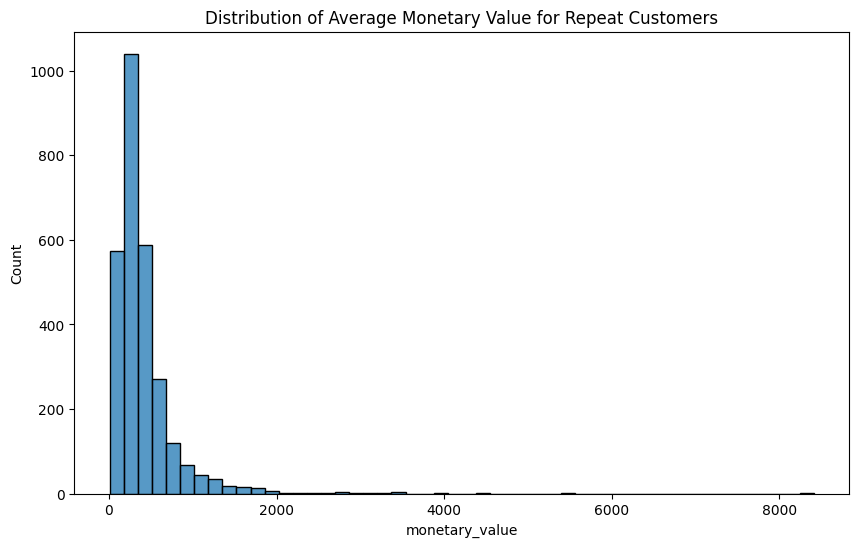

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

repeat_customers = rfm_df[rfm_df['frequency'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(repeat_customers['monetary_value'], bins=50)
plt.title('Distribution of Average Monetary Value for Repeat Customers')
plt.show()

We have now successfully transformed the raw transaction log into a powerful, customer-centric feature set. This rfm_df table is the exact input our predictive models need.

Model Training

Objective: To train two probabilistic models on our RFM data. The first model will predict future transaction frequency, and the second will predict the monetary value of those transactions.

We will divide it into two-part prediction:

How often will a customer buy? (BG/NBD Model)

How much will they spend when they buy? (Gamma-Gamma Model)

1. Part 1: Training the Transaction Model (BG/NBD)
The BG/NBD (Beta-Geometric/Negative Binomial Distribution) model analyzes the recency and frequency of past purchases to predict future buying behavior. It calculates the probability that a customer is still "alive" (i.e., hasn't churned) and how many transactions they are likely to make in a future time period.

In [18]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)

bgf.fit(rfm_df['frequency'], rfm_df['recency'], rfm_df['T'])

print(bgf.summary)

             coef    se(coef)  lower 95% bound  upper 95% bound
r        0.873416    0.028404         0.817743         0.929088
alpha   71.773688    2.704104        66.473644        77.073732
a        0.265301    1.211619        -2.109471         2.640073
b      180.662227  883.397449     -1550.796773      1912.121227


2. Part 2: Training the Monetary Model (Gamma-Gamma)
The Gamma-Gamma model works by assuming that the average transaction value for each customer follows a Gamma distribution. It uses this to predict the most likely average transaction value for each customer in the future.

The Gamma-Gamma model assumes that there is no correlation between a customer's frequency and their monetary value. We must check this before training.

In [19]:
repeat_customers_df = rfm_df[rfm_df['frequency'] > 0]

correlation_matrix = repeat_customers_df[['frequency', 'monetary_value']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                 frequency  monetary_value
frequency        1.000000        0.186686
monetary_value   0.186686        1.000000


Since the correlation is less than 0.3 we can proceed futher

In [20]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.0)

ggf.fit(repeat_customers_df['frequency'],
        repeat_customers_df['monetary_value'])

print(ggf.summary)

         coef   se(coef)  lower 95% bound  upper 95% bound
p    2.205296   0.121240         1.967665         2.442926
q    3.621314   0.148011         3.331212         3.911416
v  501.979604  45.330079       413.132649       590.826559


We have now successfully trained two sophisticated models:

The BG/NBD model understands the transactional behavior of the customers.

The Gamma-Gamma model understands the monetary value of their purchases.

These two models are now ready to be combined to predict the end-to-end Customer Lifetime Value.

CLV Calculation & Business Insights

Objective: To use the trained BG/NBD and Gamma-Gamma models to predict the 12-month Customer Lifetime Value for each customer. We will then analyze these predictions to segment customers and suggest targeted business strategies.

1. Calculating the 12-Month CLV

The lifetimes library makes this final calculation straightforward. The fitted Gamma-Gamma model object (ggf) has a built-in method, customer_lifetime_value, that combines both models to predict CLV.

In [21]:
time_in_months = 12

rfm_df['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    rfm_df['frequency'],
    rfm_df['recency'],
    rfm_df['T'],
    rfm_df['monetary_value'],
    time=time_in_months,
    freq='D', 
    discount_rate=0.01 
)

print("Top 10 Customers by Predicted 12-Month CLV:")
print(rfm_df.sort_values(by='predicted_clv', ascending=False).head(10))

Top 10 Customers by Predicted 12-Month CLV:
             frequency  recency      T  monetary_value  predicted_clv
Customer ID                                                          
18102             42.0    373.0  374.0     8259.002619  255802.323276
14646             45.0    363.0  373.0     5393.010222  179013.813277
14156             78.0    367.0  374.0     2506.409487  143008.957841
14911            127.0    373.0  374.0     1192.235748  110216.869378
13694             48.0    362.0  371.0     2685.693750   95649.109282
17511             24.0    370.0  373.0     3393.022083   60547.015087
16754             18.0    269.0  277.0     3505.892778   59666.326928
16684             18.0    353.0  368.0     4407.782778   59521.444899
15061             40.0    371.0  374.0     2000.241000   59290.255138
17949             42.0    366.0  373.0     1386.942857   43314.981373


This new predicted_clv column represents the estimated monetary value we can expect from each customer over the next year, discounted to its present value.

2. Analyzing and Visualizing the CLV Predictions

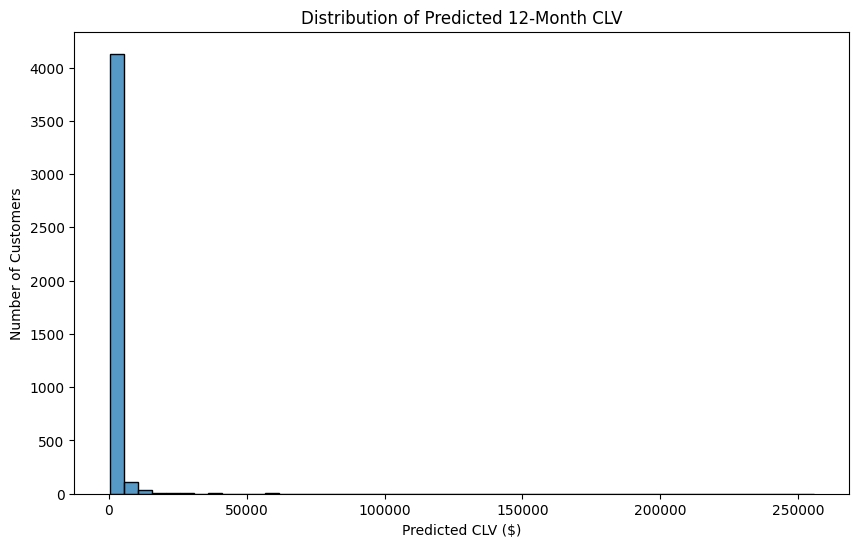

count      4312.000000
mean       1949.593864
std        6473.398460
min         279.087387
25%         640.758081
50%        1073.705668
75%        1780.106100
max      255802.323276
Name: predicted_clv, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(rfm_df['predicted_clv'], bins=50)
plt.title('Distribution of Predicted 12-Month CLV')
plt.xlabel('Predicted CLV ($)')
plt.ylabel('Number of Customers')
plt.show()

print(rfm_df['predicted_clv'].describe())

The plot is very skewed, confirming the "Pareto Principle": a small percentage of customers are responsible for a large portion of revenue.

3. Deriving Actionable Business Insights through Segmentation

Now we would translate our work into business strategy. We'll segment customers into tiers based on their predicted CLV.



In [23]:
rfm_df['clv_segment'] = pd.qcut(rfm_df['predicted_clv'],
                                q=4,
                                labels=['Low Value', 'Medium Value', 'High Value', 'VIP'])

print(rfm_df.groupby('clv_segment')['predicted_clv'].agg(['count', 'mean', 'sum']))

              count         mean           sum
clv_segment                                   
Low Value      1078   440.939908  4.753332e+05
Medium Value   1078   861.579258  9.287824e+05
High Value     1078  1372.115674  1.479141e+06
VIP            1078  5123.740616  5.523392e+06


Now, we can propose targeted strategies for each segment:

VIP Customers: These are the most valuable customers.

Strategy: Retain and Reward. Implement a loyalty program, offer exclusive early access to new products, provide personalized customer support, and send thank-you gifts. The goal is to make them feel valued and prevent churn.

High-Value Customers: These are consistent, valuable customers.

Strategy: Upsell and Nurture. Use targeted marketing to recommend products related to their past purchases. Offer "buy more, save more" promotions to increase their average order value and turn them into VIPs.

Medium-Value Customers: These customers are active but less frequent or spend less.

Strategy: Re-engage and Incentivize. Use email marketing campaigns with special offers to increase their purchase frequency. Focus on increasing their engagement with the brand.

Low-Value Customers: This group includes many one-time buyers.

Strategy: Automate and Minimize Cost. Keep them engaged through low-cost, automated email newsletters. Don't spend significant marketing dollars trying to re-acquire them. The focus is on maximizing profit from any purchase they do make.

In [24]:
rfm_df.reset_index(inplace=True)

rfm_df.to_csv('clv_dashboard_data.csv', index=False)